# model

In [21]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [22]:
# knob 종류 및 바운드
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

    "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [23]:
# config(knob) data
config_df = pd.read_csv("../data/result_config_r10000_rdb.csv", sep=',')

# 1250 개 추출
config_df = config_df.iloc[0:1250,:]
config_df.shape

# external(throughput) data
# external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')
external_df = pd.read_csv("../data/external_metrics_r10000_rdb.csv", sep=',')
# 1250 개 추출
external_df = external_df.iloc[0:1250,:]
external_df.shape

In [24]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [25]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset['activedefrag'].fillna(value='no', inplace=True)  # activedefrag no 채우기
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [26]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1056,4,114,...,6,yes,no,no,615,232,no,23,no,52805.98
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805,2,343,...,7,yes,no,no,496,156,yes,36,no,51890.64
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,776,6,194,...,5,no,yes,no,494,135,no,37,no,52373.84


In [27]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [28]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [29]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [30]:
dataset.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,615,232,no,23,no,1056,4,114,13,57,...,0.0,0.0,0.0,2000,volatile-lru,6,yes,no,no,52805.98
1,496,156,yes,36,no,805,2,343,23,47,...,0.0,0.0,0.0,1200,allkeys-lru,7,yes,no,no,51890.64
2,494,135,no,37,no,776,6,194,46,61,...,77.0,2.0,71.0,1800,volatile-random,5,no,yes,no,52373.84


### 이상치 처리

In [31]:
# 이상치 인덱스 반환 함수
def get_outlier(df=None, column=None, weight=1.5):
    
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='throughput'>

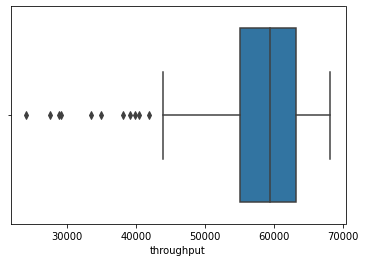

In [32]:
import seaborn as sns
sns.boxplot(dataset['throughput'])

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='throughput'>

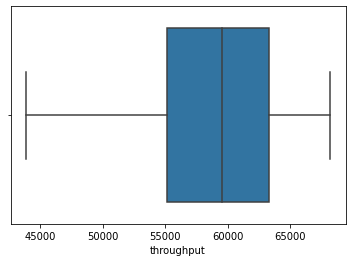

In [33]:
outlier_index = get_outlier(dataset, 'throughput')

# 이상치 제거
dataset.drop(outlier_index, axis=0, inplace = True)
sns.boxplot(dataset['throughput'])

In [34]:
# 원핫인코딩
dataset_ohe = pd.get_dummies(dataset, columns = category_knob)
dataset_ohe.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
0,615,232,23,1056,4,114,13,57,8497,0.0,...,0,1,1,0,1,0,1,0,1,0
1,496,156,36,805,2,343,23,47,8561,0.0,...,0,1,1,0,1,0,0,1,1,0
2,494,135,37,776,6,194,46,61,11337,30.0,...,1,0,0,1,1,0,1,0,1,0


In [35]:
dataset_ohe.drop(columns = ['throughput'])

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
0,615,232,23,1056,4,114,13,57,8497,0.0,...,0,1,1,0,1,0,1,0,1,0
1,496,156,36,805,2,343,23,47,8561,0.0,...,0,1,1,0,1,0,0,1,1,0
2,494,135,37,776,6,194,46,61,11337,30.0,...,1,0,0,1,1,0,1,0,1,0
3,491,76,16,742,9,295,59,57,8989,0.0,...,1,0,1,0,1,0,0,1,1,0
4,332,80,21,985,5,225,90,41,11978,0.0,...,0,1,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,575,127,24,1027,4,261,64,60,9983,0.0,...,1,0,1,0,1,0,0,1,0,1
1696,743,111,25,1032,8,483,55,62,11370,0.0,...,1,0,0,1,1,0,0,1,1,0
1697,335,172,18,797,4,311,28,41,10476,0.0,...,0,1,1,0,1,0,1,0,0,1
1698,520,226,17,887,8,332,70,67,11531,0.0,...,0,1,1,0,0,1,1,0,0,1


### test, train 데이터 분리

In [36]:
# #  정확도 확인용 train 8, test 2
# X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.iloc[:,:-1]
#                                                     , dataset['throughput'] 
#                                                     ,test_size=0.2
#                                                    , random_state = 156)

# # train 8 val 2
# X_train, X_val, y_train, y_val = train_test_split(X_train_val
#                                                     , y_train_val 
#                                                     ,test_size=0.2
#                                                    , random_state = 156)


# 전체 데이터 train 8, val 2
X_train, X_val, y_train, y_val = train_test_split(dataset.iloc[:,:-1]
                                                    , dataset['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)


In [37]:
# X_train 확인
X_train.head()

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
1574,502,223,15,871,8,379,19,67,11245,23.0,...,1,0,1,0,1,0,1,0,1,0
1112,643,213,33,979,3,310,73,30,10719,0.0,...,0,1,0,1,1,0,1,0,0,1
9,706,117,27,747,1,285,26,67,10536,1.0,...,0,1,0,1,0,1,1,0,1,0
1212,605,254,2,930,1,404,99,34,11337,0.0,...,0,1,1,0,1,0,0,1,1,0
692,726,87,11,780,4,273,45,46,8535,18.0,...,1,0,1,0,0,1,0,1,0,1


In [38]:
# knob 리스트 인덱스 수정
knobs_list = X_train.columns.tolist()
# knobs_bound = list(knobs_rdb.values())

In [39]:
# # test, train 에 비슷하게 분류됬는지 확인
# y_train.hist()
# plt.title('train data')
# plt.show()

# y_test.hist()
# plt.title('test data')
# plt.show()

## XGBoost 모델 생성

In [40]:
from xgboost import XGBRegressor

# 모델 객체 생성, n_estimators = 400으로 설정
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1)

# 검증 데이터(validation data)
evals = [(X_val.values, y_val.values)]

xgb_reg.fit(X_train.values, y_train.values, early_stopping_rounds=100, 
                eval_set = evals, verbose = True)


[0]	validation_0-rmse:53498.19922
[1]	validation_0-rmse:48205.54297
[2]	validation_0-rmse:43447.41406
[3]	validation_0-rmse:39171.03906
[4]	validation_0-rmse:35328.96094
[5]	validation_0-rmse:31878.53125
[6]	validation_0-rmse:28781.42383
[7]	validation_0-rmse:26003.21094
[8]	validation_0-rmse:23512.97070
[9]	validation_0-rmse:21282.93164
[10]	validation_0-rmse:19293.03320
[11]	validation_0-rmse:17513.78711
[12]	validation_0-rmse:15926.42188
[13]	validation_0-rmse:14516.22363
[14]	validation_0-rmse:13271.43652
[15]	validation_0-rmse:12166.44922
[16]	validation_0-rmse:11229.56934
[17]	validation_0-rmse:10376.08789
[18]	validation_0-rmse:9626.28027
[19]	validation_0-rmse:8989.45117
[20]	validation_0-rmse:8428.59375
[21]	validation_0-rmse:7949.92725
[22]	validation_0-rmse:7528.09424
[23]	validation_0-rmse:7175.76904
[24]	validation_0-rmse:6874.26465
[25]	validation_0-rmse:6625.13379
[26]	validation_0-rmse:6403.25928
[27]	validation_0-rmse:6229.88721
[28]	validation_0-rmse:6079.82373
[29]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 성능 평가

In [41]:
# 성능 측정 함수 RMSLE(캐글에서 요구한 성능 평가 방법), MSE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산 
def rmsle(y, pred):
    # log1p 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    # squred 계산
    squared_error = (log_y-log_pred)**2
    
    # RMSE 계산
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    

In [42]:
preds = xgb_reg.predict(X_test)  # 예측 결과
evaluate_regr(y_test, preds)

RMSLE: 0.089, RMSE: 5210.305, MAE: 4335.106


이상치 제거 전 RMSLE: 0.060, RMSE: 3492.223, MAE: 3032.843

이상치 제거 후 RMSLE: 0.058, RMSE: 3393.720, MAE: 2974.377

In [43]:
X_test.iloc[:1,:]

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
1013,624,77,25,958,6,123,52,74,8923,0.0,...,1,0,1,0,0,1,1,0,0,1


In [44]:
# lgbm_wrapper.predict(X_test.iloc[3:4,:])

디폴트: 44428.73653257356

전체 BO 결과: 44791.058093691274

In [45]:
# df_result_test2

In [46]:
# lgbm_wrapper.predict(df_result_test2)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

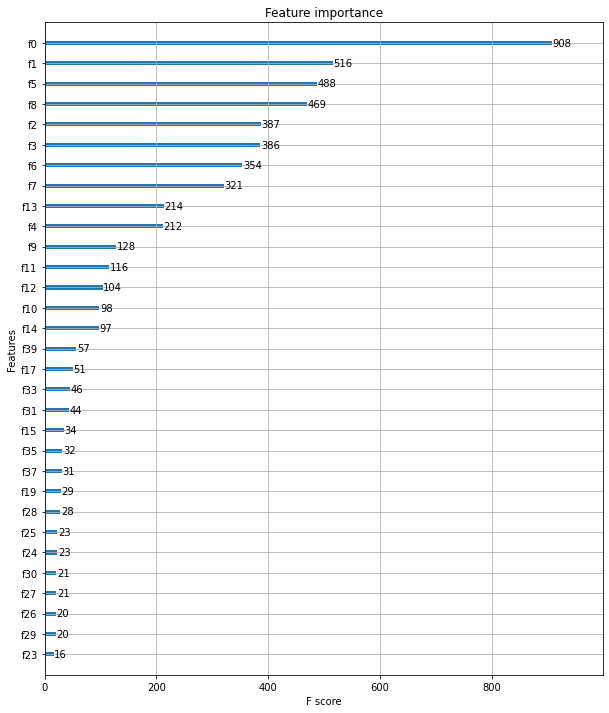

In [47]:
# plot_importance()를 이영해 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_reg, ax= ax)

---

# BO

모델은 같은 것을 사용한다.

knob_default 딕셔너리 


1. 목적함수에서 지정한 범위knob 값을 랜덤하게 추출
2. 목적함수에는 init_knob 값이 지정되어있고 나머지 값들은 들어오는 값으로 초기화
목적함수 들어가기 전에 미리 선택을 해야 한다. 범위에 대해서 

cluster0 값만준다.
목적함수에서는 받은 cluster0을 할당한다
할당되지 않은 Knob에 대해서는 knob_init를 참고하여 값을 할당한다. 

결과값을 init_dict에 할당한다. 
목적함세어는 받은 cluster1을 할당한다.
할당되지 않은 Knob에 대해서는 knob_init을 참고한다. 




## 목적함수

In [50]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):

    knob_dict = {}
    for knob in knobs_list: # 순서에 맞게 선언
        knob_dict[knob] = 'x'
    
#     print('###x 삽입###')
#     print(knob_dict)
    
    # knob_value 값 먼저 할당, knobs에 클러스터 이름 들어있다. 
    for idx,knob in enumerate(knobs):
        # 범주형 변수 처리
        if knob in category_knob:
            if knob_value[idx] == 'no':
                knob_dict[knob+'_no'] = 1
                knob_dict[knob+'_yes'] = 0
                
            elif knob_value[idx] == 'yes':
                knob_dict[knob+'_no'] = 0
                knob_dict[knob+'_yes'] = 1
            else:  # maxmemory-policy
                mmp_list = [
                        'maxmemory-policy_allkeys-lfu', 
                        'maxmemory-policy_allkeys-lru',
                        'maxmemory-policy_allkeys-random', 
                        'maxmemory-policy_noeviction',
                        'maxmemory-policy_volatile-lfu', 
                        'maxmemory-policy_volatile-lru',
                        'maxmemory-policy_volatile-random', 
                        'maxmemory-policy_volatile-ttl',
                ]
                mmp_list.remove(knob+'_'+knob_value[idx])
                knob_dict[knob+'_'+knob_value[idx]] = 1
                
                for mmp in mmp_list:
                    knob_dict[mmp] = 0
            continue
            
        # 수치형 변수는 할당    
        knob_dict[knob] = knob_value[idx]
    

    
#     print('##먼저할당##')
#     print(knob_dict)
    
    
    # 나머지 값 채우기 
    for knob ,knob_val in knob_dict.items():
        if knob_val == 'x':
            knob_dict[knob] = knobs_update[knob]
            
#     print('##나머지 update 반영 할당##')
#     print(knob_dict)
                    
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    return -xgb_reg.predict(knob_df.values)[0]


## gp_minimize

In [51]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [118]:
# knob 종류 및 바운드

cluster_table = {
        'clsuter0':
    [
        'active-defrag-cycle-min',

        'save1_1',
        'save2_0',
        'save2_1',
        'maxmemory',
        'maxmemory-samples',
        'hash-max-ziplist-value',

        'rdbcompression',
        'rdbchecksum',
        'dynamic-hz'
    ],
    'cluster1':[
        'active-defrag-threshold-lower',
        'active-defrag-threshold-upper',
        'active-defrag-cycle-max',

        'save0_0',
        'save0_1',
        'save1_0',
        'hash-max-ziplist-entries',
        'hz',

        'rdb-save-incremental-fsync',
        'lazyfree-lazy-eviction',
        'lazyfree-lazy-expire',
        'lazyfree-lazy-server-del',
        'activerehashing'
     ]

}


knobs_update = {

    'hash-max-ziplist-entries': 512,
    'hash-max-ziplist-value': 64,
    
    'activerehashing_no': 0,
    'activerehashing_yes': 1,

    'hz': 10,
    
    'dynamic-hz_no': 0,
    'dynamic-hz_yes': 1,
    
    'save0_0': 900,
    'save0_1':1,
    'save1_0': 300,
    'save1_1':10,
    'save2_0': 60,
    'save2_1':10000,
    
    'rdbcompression_no': 0,
    'rdbcompression_yes': 1,
    
    'rdbchecksum_no': 0,
    'rdbchecksum_yes': 1,
    'rdb-save-incremental-fsync_no': 0,
    'rdb-save-incremental-fsync_yes': 1,
    
    'activedefrag_no': 0,
    'activedefrag_yes': 1,

    
    'active-defrag-threshold-lower': 10,
    'active-defrag-threshold-upper': 100,
    'active-defrag-cycle-min': 5,
    'active-defrag-cycle-max': 75,
    'maxmemory': 0,
    
    'maxmemory-policy_allkeys-lfu':0, 
    'maxmemory-policy_allkeys-lru':0,
    'maxmemory-policy_allkeys-random':0, 
    'maxmemory-policy_noeviction':1,
    'maxmemory-policy_volatile-lfu':0, 
    'maxmemory-policy_volatile-lru':0,
    'maxmemory-policy_volatile-random':0, 
    'maxmemory-policy_volatile-ttl':0,
    
    'maxmemory-samples': 5,
    
    'lazyfree-lazy-eviction_no': 1,
    'lazyfree-lazy-eviction_yes': 0,

    'lazyfree-lazy-expire_no': 1,
    'lazyfree-lazy-expire_yes': 0,    
    
    'lazyfree-lazy-server-del_no': 1,
    'lazyfree-lazy-server-del_yes': 0

}


In [119]:
res_result = []
knob_update_list = []

for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    # 클러스터 내부 knob 별로 진행 
    for cluster, knobs in cluster_table.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_rdb[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
            
                    acq_func="EI",      
                    n_calls=3,      # 총 반복 횟수
                    n_random_starts=2,    # 초기 랜덤 값
                    noise=0.1**2,       
        )
        

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        res_result.append(res)
        gp_result = res.x
        iter_per_res = res.fun

        for idx,knob in enumerate(knobs):
            # 범주형 변수 처리
            if knob in category_knob:
                if gp_result[idx] == 'no':
                    knobs_update[knob+'_no'] = 1
                    knobs_update[knob+'_yes'] = 0

                elif gp_result[idx] == 'yes':
                    knobs_update[knob+'_no'] = 0
                    knobs_update[knob+'_yes'] = 1
                else:  # maxmemory-policy
                    mmp_list = [
                            'maxmemory-policy_allkeys-lfu', 
                            'maxmemory-policy_allkeys-lru',
                            'maxmemory-policy_allkeys-random', 
                            'maxmemory-policy_noeviction',
                            'maxmemory-policy_volatile-lfu', 
                            'maxmemory-policy_volatile-lru',
                            'maxmemory-policy_volatile-random', 
                            'maxmemory-policy_volatile-ttl',
                    ]
                    mmp_list.remove(knob+'_'+gp_result[idx])
                    knobs_update[knob+'_'+gp_result[idx]] = 1

                    for mmp in mmp_list:
                        knobs_update[mmp] = 0
                continue

            # 수치형 변수는 할당    
            knobs_update[knob] = gp_result[idx]
                
        knob_update_list.append(knobs_update.copy())
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter0#####
0-th
[-56883.785 -54892.457 -55805.227]
-56883.785
#####cluster1#####
0-th
[-59454.387 -60350.48  -59871.336]
-60350.48
-60350.48



63095.395

In [121]:
knob_update_list[1]

{'hash-max-ziplist-entries': 643,
 'hash-max-ziplist-value': 211,
 'activerehashing_no': 0,
 'activerehashing_yes': 1,
 'hz': 17,
 'dynamic-hz_no': 1,
 'dynamic-hz_yes': 0,
 'save0_0': 816,
 'save0_1': 6,
 'save1_0': 101,
 'save1_1': 72,
 'save2_0': 47,
 'save2_1': 11423,
 'rdbcompression_no': 1,
 'rdbcompression_yes': 0,
 'rdbchecksum_no': 0,
 'rdbchecksum_yes': 1,
 'rdb-save-incremental-fsync_no': 0,
 'rdb-save-incremental-fsync_yes': 1,
 'activedefrag_no': 0,
 'activedefrag_yes': 1,
 'active-defrag-threshold-lower': 26,
 'active-defrag-threshold-upper': 84,
 'active-defrag-cycle-min': 14,
 'active-defrag-cycle-max': 89,
 'maxmemory': 1212,
 'maxmemory-policy_allkeys-lfu': 0,
 'maxmemory-policy_allkeys-lru': 0,
 'maxmemory-policy_allkeys-random': 0,
 'maxmemory-policy_noeviction': 1,
 'maxmemory-policy_volatile-lfu': 0,
 'maxmemory-policy_volatile-lru': 0,
 'maxmemory-policy_volatile-random': 0,
 'maxmemory-policy_volatile-ttl': 0,
 'maxmemory-samples': 4,
 'lazyfree-lazy-eviction_no

In [96]:
res_result[4].x

IndexError: list index out of range

63095.395

hash-max-ziplist-entries 256
hash-max-ziplist-value 257
activerehashing yes
hz 6
dynamic-hz yes 
save 920 6 
save 293 10
save 51 9460

rdbcompression yes 
rdbchecksum yes
rdb-save-incremental-fsync yes

activedefrag yes
active-defrag-threshold-lower 22
active-defrag-threshold-upper 77
active-defrag-cycle-min 20
active-defrag-cycle-max 77
maxmemory 2900mb
maxmemory-policy noeviction
maxmemory-samples 6
 'lazyfree-lazy-eviction_no': 1,
 'lazyfree-lazy-expire_no': 1,
 'lazyfree-lazy-server-del_no': 1,
 'rdbcompression': 'no',
 'rdbchecksum': 'no',
 'dynamic-hz': 'no',
 'rdb-save-incremental-fsync': 'no',
 'lazyfree-lazy-eviction': 'yes',
 'lazyfree-lazy-expire': 'yes',
 'lazyfree-lazy-server-del': 'no',
 'activerehashing': 'no'

### knob 전체 대상

In [59]:
# 전체 데이터 대상
res_result = []

cluster_table_T = {

    'clsuter1':
    [
        'save1_1', 
        'lazyfree-lazy-eviction',

        'active-defrag-cycle-min',
        'active-defrag-cycle-max',
        'save0_0',
        'save0_1',
        'save2_0',
        'save2_1',
        'maxmemory-samples',
        'hash-max-ziplist-entries',
        'hash-max-ziplist-value',
        'lazyfree-lazy-expire',
        'dynamic-hz',
        'hz',
        'activerehashing',
        'save1_0',
        'rdbcompression',
        'rdbchecksum',
        'rdb-save-incremental-fsync',
        'activedefrag',
        'active-defrag-threshold-lower',
        'active-defrag-threshold-upper',
        'maxmemory',
        'maxmemory-policy',
        'lazyfree-lazy-server-del'

               ]
}

knobs_update = {

    'hash-max-ziplist-entries': 'x',
    'hash-max-ziplist-value': 'x',
    'activerehashing': 'x',
    'hz': 'x',
    'dynamic-hz': 'x',
    'save0_0': 'x',
    'save0_1':'x',
    'save1_0': 'x',
    'save1_1':'x',
    'save2_0': 'x',
    'save2_1':'x',
    'rdbcompression': 'x',
    'rdbchecksum': 'x',
    'rdb-save-incremental-fsync': 'x',
    'activedefrag': 'x',
    'active-defrag-threshold-lower': 'x',
    'active-defrag-threshold-upper': 'x',
    'active-defrag-cycle-min': 'x',
    'active-defrag-cycle-max': 'x',
    'maxmemory': 'x',
    'maxmemory-policy':'x',
    'maxmemory-samples': 'x',
    'lazyfree-lazy-eviction': 'x',
    'lazyfree-lazy-expire': 'x',
    'lazyfree-lazy-server-del': 'x'

}


# knobs_update = {

#     'hash-max-ziplist-entries': 270,
#     'hash-max-ziplist-value': 63,
#     'activerehashing': 'no',
#     'hz': 40,
#     'dynamic-hz': 'yes',
#     'save0_0': 829,
#     'save0_1':1,
#     'save1_0': 355,
#     'save1_1':100,
#     'save2_0': 31,
#     'save2_1':8478,
#     'rdbcompression': 'no',
#     'rdbchecksum': 'no',
#     'rdb-save-incremental-fsync': 'yes',
#     'activedefrag': 'yes',
#     'active-defrag-threshold-lower': 12,
#     'active-defrag-threshold-upper': 86,
#     'active-defrag-cycle-min': 10,
#     'active-defrag-cycle-max': 80,
#     'maxmemory': 2039,
#     'maxmemory-policy':'noeviction',
#     'maxmemory-samples': 3,
#     'lazyfree-lazy-eviction': 'no',
#     'lazyfree-lazy-expire': 'yes',
#     'lazyfree-lazy-server-del': 'no'

# }



for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    for cluster, knobs in cluster_table_T.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_rdb[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
#                     x0 = x0_list,
#                     y0 = y0_val, 
            
                    acq_func="EI",      
                    n_calls=30,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )   

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        gp_result = res.x
        iter_per_res = res.fun
        res_result.append(res)
        
#         x0_list = res.x
#         y0_val = res.fun
        
        for idx,knob in enumerate(knobs):
            knobs_update[knob] = gp_result[idx]
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter1#####
0-th
[-60290.4   -56665.367 -61220.816 -58191.598 -59024.758 -48088.676
 -46966.28  -59509.17  -54834.848 -53144.94  -59064.312 -52933.156
 -52872.53  -49051.074 -56683.945 -52054.99  -60066.38  -57030.824
 -56003.52  -55329.832 -59179.65  -57394.95  -53047.656 -56233.734
 -61276.96  -55425.277 -55531.395 -62015.867 -60236.926 -59552.176]
-62015.867
-62015.867



62152.168

hash-max-ziplist-entries 453
hash-max-ziplist-value 120
activerehashing no
hz 4
dynamic-hz no
save 810 6
save 409 69
save 33 8178
rdbcompression no
rdbchecksum yes
rdb-save-incremental-fsync yes
activedefrag no
active-defrag-threshold-lower 18
active-defrag-threshold-upper 85
active-defrag-cycle-min 19
active-defrag-cycle-max 79
maxmemory 1716mb
maxmemory-policy allkeys-lfu
maxmemory-samples 6
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del yes

In [60]:
knobs_update

{'hash-max-ziplist-entries': 453,
 'hash-max-ziplist-value': 120,
 'activerehashing': 'no',
 'hz': 4,
 'dynamic-hz': 'no',
 'save0_0': 810,
 'save0_1': 6,
 'save1_0': 409,
 'save1_1': 69,
 'save2_0': 33,
 'save2_1': 8178,
 'rdbcompression': 'no',
 'rdbchecksum': 'yes',
 'rdb-save-incremental-fsync': 'yes',
 'activedefrag': 'no',
 'active-defrag-threshold-lower': 18,
 'active-defrag-threshold-upper': 85,
 'active-defrag-cycle-min': 19,
 'active-defrag-cycle-max': 79,
 'maxmemory': 1716,
 'maxmemory-policy': 'allkeys-lfu',
 'maxmemory-samples': 6,
 'lazyfree-lazy-eviction': 'yes',
 'lazyfree-lazy-expire': 'no',
 'lazyfree-lazy-server-del': 'yes'}

In [62]:
knob_to_dict(knobs_update)

hash-max-ziplist-entries 453
hash-max-ziplist-value 120
activerehashing no
hz 4
dynamic-hz no
save0_0 810
save0_1 6
save1_0 409
save1_1 69
save2_0 33
save2_1 8178
rdbcompression no
rdbchecksum yes
rdb-save-incremental-fsync yes
activedefrag no
active-defrag-threshold-lower 18
active-defrag-threshold-upper 85
active-defrag-cycle-min 19
active-defrag-cycle-max 79
maxmemory 1716
maxmemory-policy allkeys-lfu
maxmemory-samples 6
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del yes


---

In [61]:
def knob_to_dict(knob_dict):
    for key, val in knob_dict.items():            
        print(key, end=' ')
        print(val)

## gp 결과 정리

### gp 분류된것
"hash-max-ziplist-entries" : 284
'hash-max-ziplist-value' 22
'activerehashing': 'yes'
'hz' 32
'dynamic-hz' : 'yes'
'save0_0' : 877
'save0_1'2
'save1_0'272
'save1_1' : 12
'save2_0'33
'save2_1' : 11669 
'rdbcompression'no
'rdbchecksum' yes
"rdb-save-incremental-fsync" 'no'
'active-defrag-threshold-lower'3
'active-defrag-threshold-upper': 87
'active-defrag-cycle-min' : 25
'active-defrag-cycle-max' : 80
'maxmemory'1298
maxmemory-policy : 'allkeys-random' 
'maxmemory-samples'6
"lazyfree-lazy-eviction"  'no'
'lazyfree-lazy-expire' yes
'lazyfree-lazy-server-del' yes


### gp 분류된것2
hash-max-ziplist-entries 502
hash-max-ziplist-value 213
activerehashing yes
hz 32
dynamic-hz yes
save0_0 760
save0_1 3
save1_0 426
save1_1 24
save2_0 37
save2_1 8052 
rdbcompression no
rdbchecksum' no
rdb-save-incremental-fsync yes
active-defrag-threshold-lower 4
active-defrag-threshold-upper 72
active-defrag-cycle-min 14
active-defrag-cycle-max 70
maxmemory 1552
maxmemory-policy allkeys-random
maxmemory-samples 6
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no
[575,
 94,
 'no',
 10,
 'yes',
 1072,
 5,
 465,
 24,
 83,
 9398,
 'yes',
 'yes',
 'no',
 26,
 81,
 20,
 75,
 1539,
 'allkeys-lfu',
 4,
 'yes',
 'no',
 'no']

### gp_T
hash-max-ziplist-entries 575
hash-max-ziplist-value 94
activerehashing no
hz 10
dynamic-hz yes
save0_0 1072
save0_1 5
save1_0 465
save1_1 24
save2_0 83
save2_1 9398
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
active-defrag-threshold-lower 26
active-defrag-threshold-upper 81
active-defrag-cycle-min 20
active-defrag-cycle-max 75
maxmemory 1539
maxmemory-policy allkeys-lfu
maxmemory-samples 4
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del no

